# Demonstration of:
#      - 1. altering the objective function and comparing calibrations
#      - 2. getting streamflow data direct from BoM using scripting


Workbook layout:
   1. Read historical benchmarking streamflow data from csv and get shapefile information
   2. Calibrate using standard Nash-Sutcliffe Efficiency (NSE) objective function and added Kling-Gupta Efficiency (KGE) 
   3. Get Extended data from BoM Water Data Online and compare to benchmarking data
   

#   1. Read shapefile and historical data from csv

In [2]:
# get catchments shapes and IDs used for benchmarking from shapefile
from awrams.utils.io.data_mapping import SplitFileManager
from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE
from awrams.utils.settings import TRAINING_DATA_PATH
from awrams.benchmarking.utils import read_id_csv
catchments = ShapefileDB(CATCHMENT_SHAPEFILE)
records=catchments.get_records_df()
records['StationID'].head()
data_path = TRAINING_DATA_PATH+'/benchmarking/'
catchment_csv = data_path+'/catchment_ids.csv'
id_list=read_id_csv(catchment_csv)
obs_csv = data_path+ '/runoff/Catchment_Qobs.csv'
import pandas as pd
qobs=pd.read_csv(obs_csv,index_col =0)
# get site ids and start dates etc for comparison
ids=records['StationID']  # ids as used in awra-l system (often concatenated wrsc)
wrsids=records['WrscID'] # official water resource station catalogue station numbers
areas=records['AlbersArea'] # catchment areas in km^ 2
findate=records['DateQfinish'] # finish date
startdate=records['DateOpen'] # start date 

# 2. Demonstrate use of altered objective function
## Calibrate AWRA-L to a few catchments using NSE and then the Kling-Gupta Efficiency


In [ ]:
import pandas as pd
from os.path import join
import h5py
from awrams.models.awral.model import AWRALModel
from awrams.utils.nodegraph import nodes, graph
from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
from awrams.calibration.optimizers import sce
from awrams.calibration.objectives import test_objectives as tobj
from awrams.calibration.support import *
from awrams.calibration import cluster
from awrams.calibration.launch_calibration import run_from_pickle
from matplotlib import pyplot as plt
# Instantiate the AWRA-L model
awral = AWRALModel()
# Define the extenst of the calibration
def_extent = extents.get_default_extent() 
# define the location of input data (streamflow and climate)
cal_catchments=['105001','145003'] # set of 4 test data sites provided with git copy
#from awrams.models import awral
#from awrams.utils.nodegraph import nodes, graph
TRAINING_DATA_PATH='../test_data/'

def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    from os.path import join
    from os import getcwd

    # data_path = '../../test_data/calibration/' [This path to be reonfigured to place forcings in separate folders]
    data_path = TRAINING_DATA_PATH + 'climate/BOM_climate/'
    
    FORCING = {
        'tmin': ('temp_min*.nc','temp_min_day',data_path + 'temp_min_day/'),
        'tmax': ('temp_max*.nc','temp_max_day',data_path + 'temp_max_day/'),
        'precip': ('rain_day*.nc','rain_day',data_path + 'rain_day/'),
        'solar': ('solar*.nc','solar_exposure_day',data_path + 'solar_exposure_day/') #,

    }
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[2],v[0],v[1])

input_map = awral.get_default_mapping() 
change_path_to_forcing(input_map)


#input_map = insert_solar_climatology(input_map)
## Create a dict with multiple extents
cal_dict = {}
#cal_catchments=['113004','111101', '109001', '108003', '112102', '107002','105001', '116008']
#observations = dict(qtot = '../../test_data/calibration/q_obs.csv' ) - if only have limited observations
observations=dict(qtot=obs_csv)
for catchment in cal_catchments:
    cal_dict[catchment] = catchments.get_extent_by_field('StationID', catchment.zfill(6), parent_extent=def_extent)

run_period = dt.dates('2009 - 2010')
eval_period = dt.dates('2009 - 2010')
print('Calibrating over the following set of sites for 2009-2010',cal_dict)
evolver_spec = EvolverSpec(sce.CCEvolver,
                           evolver_run_args=dict(n_offspring=1,n_evolutions=5,elitism=2.0))
optimizer_spec = OptimizerSpec(sce.ShuffledOptimizer,
                               evolver_spec=evolver_spec,
                               n_complexes=5,
                               max_nsni=500,
                               min_complexes=1,
                               max_eval=2000) #n_complex 14
local_objfspec = ObjectiveFunctionSpec(tobj.TestLocalSingle)  # this function to load up the ObjFunc comes from awrams.calibration.support
global_objfspec = tobj.TestGlobalSingle
objective_spec = ObjectiveSpec(global_objfspec,
                               local_objfspec,
                               observations,
                               eval_period)
#### 2.6. Build spec dict
#Assemble above settings into specification dictionary
# Get the input mapping and model
node_mapping = input_map
model = awral#callable_to_funcspec(awral)
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = cal_dict
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
cal_spec['logfile'] = './calres.h5'
cluster.build_pickle_from_spec(cal_spec,1,'test_cal.pkl')


### Can skip this step and read in outputs as it takes a little while
#### results saved in './calres.h5'

In [3]:
# run the calibration
#from awrams.calibration.launch_calibration import run_from_pickle
import time
start = time.time()
print("Starting calibration........")
cal = run_from_pickle('./test_cal.pkl')
end = time.time()
print('Calibration complete.......')
print('Time elapsed for calibration',end - start)

Calibrating over the following set of sites for 2009-2010 {'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05, '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05}
Starting calibration........
s:  7140
n

 evaluating initial population
{}
...
 running
{'best_params': Score: 0.786444745227, Params: [ 0.03941318  0.03789217  0.07214855  0.82408072  0.92199983  0.96857639
  3.08393983  1.5451794   2.00603256  0.049638    0.46869477  8.9847855
  0.47285554  2.04910222  1.67613136  0.34570536  0.34886143  0.62934172
  0.12895572  1.62575523  1.93201036], Meta: None, 'n_eval': 263, 'n_shuffle': 2}

 running
{'best_params': Score: 0.786444745227, Params: [ 0.03941318  0.03789217  0.07214855  0.82408072  0.92199983  0.96857639
  3.08393983  1.5451794   2.00603256  0.049638    0.46869477  8.9847855
  0.47285554  2.04910222  1.67613136  0.34570536  0.34886143  0.62934172
  0.12895572  1.62575523  1.93201036], Meta: None, 'n_eval': 330, 'n_shuffle': 7}

 running
{'best_params

In [5]:
cr = CalibrationResults('./calres.h5')
params_all = cr.get_parameter_values()
best_params = params_all.iloc[cr.best_param_index()]
best_params

cgsmax_hrudr         0.020010
cgsmax_hrusr         0.043186
er_frac_ref_hrudr    0.043265
fsoilemax_hrudr      0.844426
fsoilemax_hrusr      0.967098
k0sat_scale          8.398161
k_gw_scale           0.635815
k_rout_int           1.758146
k_rout_scale         0.603175
kdsat_scale          0.025353
kr_coeff             0.821648
kssat_scale          0.470044
ne_scale             0.927066
pref_gridscale       2.944250
s0max_scale          1.682913
s_sls_hrudr          0.080386
s_sls_hrusr          0.078475
sdmax_scale          0.699876
slope_coeff          0.754197
ssmax_scale          1.337539
ud0_hrudr            6.022874
Name: 1977, dtype: float64

### Alter the objective function

#### View objective function file [calibration/objectives/test_objectives.py]

[calibration/objectives/test_objectives.py]: ../../../edit/calibration/awrams/calibration/objectives/test_objectives.py                    



In [11]:
# View current objective function...
# Code below is from within test_objectives.py
class TestLocalSingle:

    input_schema = input_group(['qtot'])
    output_schema = ['qtot_nse']

    def __init__(self,obs,eval_period,min_valid=15):

        self.valid_idx = {}
        self.nse = {}
        self.flow_variable = 'qtot'
        for k in [self.flow_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.nse[k] = NSE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_nse = self.nse[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        return np.array(qtot_nse)

class TestGlobalSingle:

    output_schema = ['objf_val']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        objf_val = 1.0 - np.mean(l_results['qtot_nse'])
        return dict(objf_val = objf_val)
    
    
  

## Define the Kling-Gupta efficiency

In [33]:
%%writefile kge_objectives.py
from awrams.calibration.support import input_group
import numpy as np
class KGE:
    '''
    Precomputed Kling-Gupta Efficiency evaluator
    '''    
    def __init__(self,obs):
        self.obs = obs

    def __call__(self,modelled):
        if modelled.size == 0:
            correl = np.NaN
        else:
            correl = np.corrcoef(self.obs, modelled)[0,1]
        alpha = np.std(modelled)/np.std(self.obs)
        beta = np.sum(modelled)/np.sum(self.obs)
        kge = 1- np.sqrt((correl-1)**2 + (alpha-1)**2 + (beta-1)**2 )
        return kge        

# Trial an alternate objective function
# Kling-Gupta efficiency
class TestLocalSingle_KGE:

    input_schema = input_group(['qtot'])
    output_schema = ['qtot_kge']

    def __init__(self,obs,eval_period,min_valid=15):

        self.valid_idx = {}
        self.kge = {}
        self.flow_variable = 'qtot'
        for k in [self.flow_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.kge[k] = KGE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_kge = self.kge[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        return np.array(qtot_kge)

class TestGlobalSingle_KGE:

    output_schema = ['objf_val']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        objf_val = 1.0 - np.mean(l_results['qtot_kge'])
        return dict(objf_val = objf_val)




Overwriting kge_objectives.py


In [34]:
# import your newly created module
import kge_objectives as kobj

In [35]:
local_objfspec = ObjectiveFunctionSpec(kobj.TestLocalSingle_KGE)  # this function to load up the ObjFunc comes from awrams.calibration.support
global_objfspec = kobj.TestGlobalSingle_KGE
objective_spec = ObjectiveSpec(global_objfspec,
                               local_objfspec,
                               observations,
                               eval_period)
#### 2.6. Build spec dict
#Assemble above settings into specification dictionary
# Get the input mapping and model
node_mapping = input_map
model = awral#callable_to_funcspec(awral)
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = cal_dict
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
cal_spec['logfile'] = './calres_KGE.h5'
cluster.build_pickle_from_spec(cal_spec,1,'test_cal_kge.pkl')

{'catch_node_map': {'105001': [0], '145003': [0]},
 'extent_map': {'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
  '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05},
 'logfile': './calres_KGE.h5',
 'model': <awrams.models.awral.model.AWRALModel at 0x7f0bf7909898>,
 'n_workers': 1,
 'node_alloc': OrderedDict([(0,
               {'catchments': [('105001',
                  {'ncells': 49, 'start_cell': 0},
                  {'owns': True, 'remote': False}),
                 ('145003',
                  {'ncells': 16, 'start_cell': 0},
                  {'owns': True, 'remote': False})],
                'cell_counts': [49, 16]})]),
 'node_mapping': alb_dry_hrudr : parameter([]):{'value': 0.26, 'min': 0.1, 'fixed': True, 'max': 0.5}
 alb_dry_hrusr : parameter([]):{'value': 0.26, 'min': 0.1, 'fixed': True, 'max': 0.5}
 alb_wet_hrudr : parameter([]):{'value': 0.16, 'min': 0.1, 'fixed': True, 'max': 0.5}
 alb_wet_hrusr : parameter([]):{'value': 0.16, 'min': 0.1, '

In [36]:
# run the calibration using KGE
#from awrams.calibration.launch_calibration import run_from_pickle
import time
start = time.time()
print("Starting calibration using KGE........")
cal = run_from_pickle('./test_cal_kge.pkl')
end = time.time()
print('Calibration complete.......')
print('Time elapsed for calibration',end - start)

Starting calibration using KGE........
n
s:  15814

 evaluating initial population
{}
....
 running
{'n_eval': 244, 'n_shuffle': 1, 'best_params': Score: 0.711570879764, Params: [ 0.0464775   0.03796931  0.16429497  0.65644304  0.79218613  5.6104551
  0.58439395  0.98798625  1.90155921  0.05314117  0.87998394  4.78809701
  0.39048851  1.93648273  0.90945449  0.5630107   0.387754    0.68309067
  0.55477658  1.05124197  2.87540746], Meta: None}

 running
{'n_eval': 337, 'n_shuffle': 7, 'best_params': Score: 0.711570879764, Params: [ 0.0464775   0.03796931  0.16429497  0.65644304  0.79218613  5.6104551
  0.58439395  0.98798625  1.90155921  0.05314117  0.87998394  4.78809701
  0.39048851  1.93648273  0.90945449  0.5630107   0.387754    0.68309067
  0.55477658  1.05124197  2.87540746], Meta: None}

 running
{'n_eval': 402, 'n_shuffle': 14, 'best_params': Score: 0.711570879764, Params: [ 0.0464775   0.03796931  0.16429497  0.65644304  0.79218613  5.6104551
  0.58439395  0.98798625  1.9015592

# 2. Get Extended data from BoM Water Data Online

### SOS2 Services for Water Data Online

The Bureau has implemented a Sensor Observation Service standard version 2 (SOS2) service to make publicly available the time series data it collects and manages under the Water Regulations 2008. The service provides data in WaterML2 format. The SOS2 standard was developed by the Open Geospatial Consortium (OGC) as part of the OGC Sensor Web Enablement framework. The WaterML2 standard was also developed by the OGC with support from the Bureau of Meteorology and CSIRO though the WIRADA research alliance.

In [38]:
cal_dict

{'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
 '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05}

In [46]:
#what is th eofficial Water Resources Station Catalogue ID of site '105001'?
wrsids[np.where(ids=='105001')[0][0]]
 

'105001B'

In [47]:
# get set of stations (xml elements) that have 'Water Course Discharge'
import awrams.utils.wiski.interface as W
wcds = W.get_station_list("Water Course Discharge") # Get discharge volume (m3/sec) from wiski for gauging stations
#### find all datasets for a station "105001"
stns = W.find_id_in_station_list('105001',wcds) 
stns  #['105001B', '105001A']

number of xml elements returned: 5955


['105001B', '105001A']

In [48]:
# View the types of data you can download usign wiski SOS
W.WISKI_CODES

{'Storage Level': {'DMQaQc.Merged.DailyMean.24HR': 'Pat7_PR02_AHD_1_DailyMean'},
 'Storage Volume': {'DMQaQc.Merged.DailyMean.24HR': 'Pat6_PR02_AV_1_DailyMean'},
 'Water Course Discharge': {'DMQaQc.Merged.DailyMean.09HR': 'Pat4_C_B_1_DailyMean09'},
 'Water Course Level': {'DMQaQc.Merged.DailyMean.24HR': 'Pat3_C_B_1_DailyMean'}}

### Plot the downloaded data for site '105001B' including quality codes

/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/utils/wiski/talk_to_wiski2.py:339: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  return get_timeseries(foi_href,prop_href,proc_href,period)


http://www.bom.gov.au/waterdata/services?service=SOS&version=2.0&request=Getobservation&featureofinterest=http://bom.gov.au/waterdata/services/stations/105001B&observedproperty=http://bom.gov.au/waterdata/services/parameters/Water%20Course%20Discharge&procedure=http://bom.gov.au/waterdata/services/tstypes/Pat4_C_B_1_DailyMean09&temporalfilter=phenomenonTime,1900-01-01/2017-10-23
number of xml elements returned: 1


/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


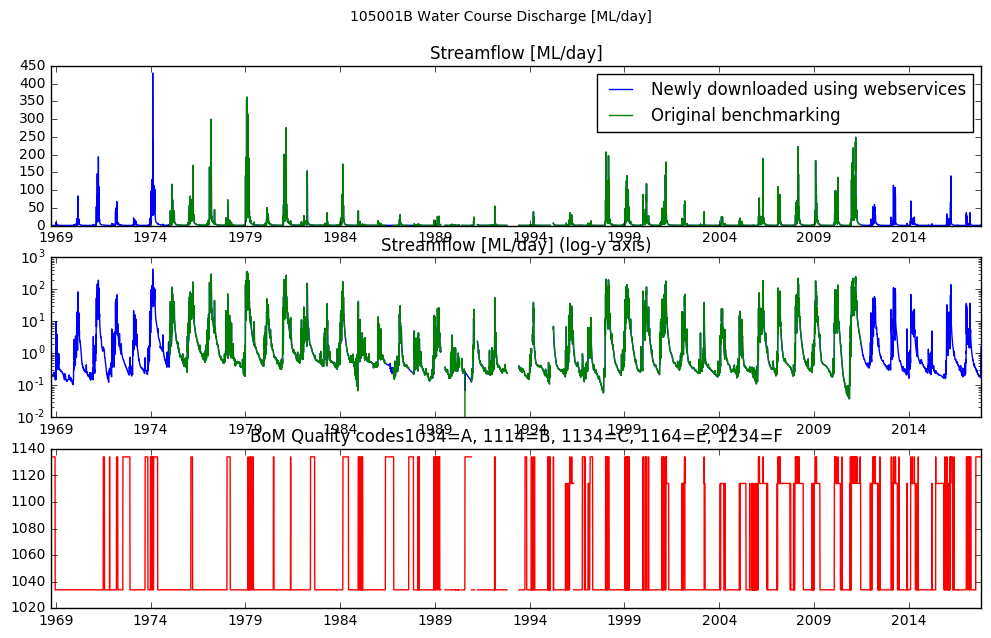

In [110]:
siteid='105001' # site id according to benchmarking dataset
whichsite=np.where(ids==siteid)[0][0] # find which of the set this corresponds to to get the true wrsids ID


# get the data 
a=pd.DataFrame(W.get_data(wrsids[whichsite],obs_type="Water Course Discharge",period=pd.date_range('1900-01-01','2017-10-23',freq='D'))) # Setup data to download from Wiski

# plot the data
%matplotlib inline
figsize=(12,7)
fig = plt.figure(figsize=figsize)
fig.suptitle(wrsids[whichsite] + ' Water Course Discharge [ML/day]')
ax1 = fig.add_subplot(3,1,1)
a1=pd.DataFrame(a['values'])
b=pd.DataFrame(qobs[str(int(ids[whichsite]))])
# Convert mm/day benchmarking data set to cumecs as per downloaded data
# Q(m^3/s) =Q (mm/day) *Catchment Area (m^2) / 1000mm/m * (24*3600second/day)   
# area is provided in km^2
# Q(m^3/s) =Q (mm/day) *Area (km^2)*1000*1000 /1000*24*3600 
#          =Q (mm/day) *Area (km^2)/24*3.6
#          =Q (mm/day) *Area (km^2)/86.4
b=b*areas[whichsite]/86.4
c=a1.join(b)
dt = pd.to_datetime(a.index, format='%Y-%m-%d')
ax1.plot_date(dt,c['values'],'-',label='Newly downloaded using webservices')
ax1.plot_date(dt,c[siteid],'-',label='Original benchmarking')
ax1.legend()
ax1.set_title('Streamflow [ML/day]')
ax1 = fig.add_subplot(3,1,2)
ax1.plot_date(dt,c,'-')  
plt.yscale('log')
ax1.set_title('Streamflow [ML/day] (log-y axis)')

# finaly qualaty codes
ax1 = fig.add_subplot(3,1,3)
ax1.plot(a['qualifier'],color='red')
ax1.set_title('BoM Quality codes'+'1034=A, 1114=B, 1134=C, 1164=E, 1234=F')
# see bom quality codes
# currently known issue in SOS with transllations of quality codes
#http://www.bom.gov.au/water/wdtf/documentation/schema-control-lists/quality-code.htm
#dictQualityCodes='1034=A, 1114=B, 1134=C, 1164=E, 1234=F'    
 

In [111]:
areas[whichsite]

991.37780499999997